# Mobile Price Range Classification with Machine Learning
Pricing is one of the hardest decisions when launching a new smartphone. Devices ship with dozens of hardware and software features, and the final price needs to balance market positioning with manufacturing and marketing costs. In this project, we frame the problem as a classification task: instead of predicting an exact price, we predict the price band a device belongs to.

<div align="center">
<img src="https://img.freepik.com/premium-vector/cartoon-hand-holding-mobile-smart-phone-with-celebratory-confetti-flying-around-winner-concept_3482-5775.jpg"/>
</div>

## Project overview
Smartphones are among the most frequently upgraded consumer electronics. With thousands of models competing at once, estimating an appropriate price tier is challenging for newcomers and established brands alike. Here, we build a model that maps device specifications to a discrete price range, which can guide product planning and competitive analysis.

We will train a supervised classifier in Python to assign each phone to one of the following classes:

1. 0 (low cost)
2. 1 (medium cost)
3. 2 (high cost)
4. 3 (very high cost)

We’ll start by importing the required Python libraries and loading the dataset available at [this link](https://raw.githubusercontent.com/amankharwal/Website-data/master/mobile_prices.csv).

## Notebook Overview
This notebook builds a multi-class classifier to predict smartphone `price_range`
from device specifications. It follows an end-to-end ML workflow:

- **Importing Libraries**: Set up core scientific Python and scikit-learn utilities.
- **Data Loading**: Load the mobile price dataset from a public URL and inspect structure.
- **Exploratory Data Analysis (EDA)**: Summaries and visualizations (distribution, pairwise plots,
  correlations) to understand relationships between features and the target.
- **Data Preprocessing**: Split features/target and scale inputs using `MinMaxScaler`.
- **Model Building & Evaluation**: Train and compare multiple algorithms (Naive Bayes,
  linear models, trees/ensembles, SVM, k-NN) using standard metrics and confusion matrices.
- **Model Selection**: Identify the best-performing approach (here, `LogisticRegression`).
- **Model Saving**: Assemble a `ColumnTransformer` + estimator pipeline and persist it with `joblib`.
- **Conclusion**: Summarize findings and outline next steps and deployment notes.

Outcome: a reproducible pipeline saved as `mobile_price_classification.pkl` that can be
integrated into applications (e.g., a Streamlit interface) for real-time predictions.

## 1. Importing Libraries
First, let’s import the necessary libraries for data manipulation, visualization, and machine learning.

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import warnings

### Configuration
Let's configure the necessary settings.
- Ignore warnings for cleaner output.
- Display up to 100 columns for better visibility.
- Set default figure size to 12x8 inches for plots.
- Use seaborn's 'darkgrid' style for improved plot aesthetics.

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

## 2. Data Loading
We will load the mobile price dataset using pandas and take a quick look at its structure.

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/amankharwal/Website-data/master/mobile_prices.csv')

In [5]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [6]:
df.shape

(2000, 21)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

## 3. Exploratory Data Analysis
Let's explore the data to get a better understanding of the variables and their relationships.

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.51850,439.418206,501.0,851.75,1226.0,1615.25,1998.0
blue,2000.0,0.49500,0.500100,0.0,0.00,0.0,1.00,1.0
clock_speed,2000.0,1.52225,0.816004,0.5,0.70,1.5,2.20,3.0
dual_sim,2000.0,0.50950,0.500035,0.0,0.00,1.0,1.00,1.0
fc,2000.0,4.30950,4.341444,0.0,1.00,3.0,7.00,19.0
four_g,2000.0,0.52150,0.499662,0.0,0.00,1.0,1.00,1.0
int_memory,2000.0,32.04650,18.145715,2.0,16.00,32.0,48.00,64.0
m_dep,2000.0,0.50175,0.288416,0.1,0.20,0.5,0.80,1.0
mobile_wt,2000.0,140.24900,35.399655,80.0,109.00,141.0,170.00,200.0
n_cores,2000.0,4.52050,2.287837,1.0,3.00,4.0,7.00,8.0


Let's start visualization with `price_range` column.

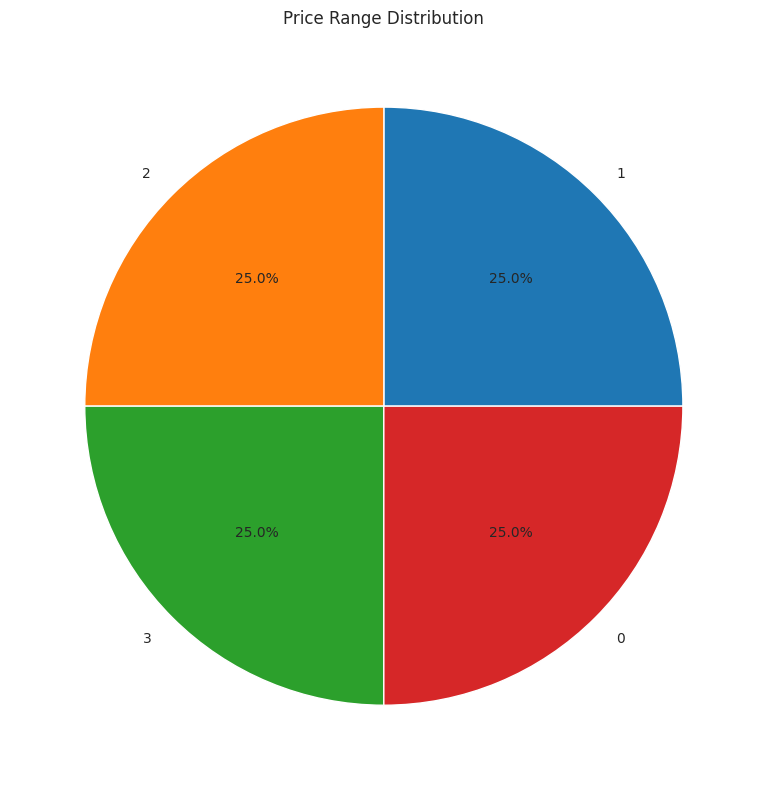

In [9]:
df['price_range'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Price Range Distribution')
plt.ylabel('')
plt.tight_layout()

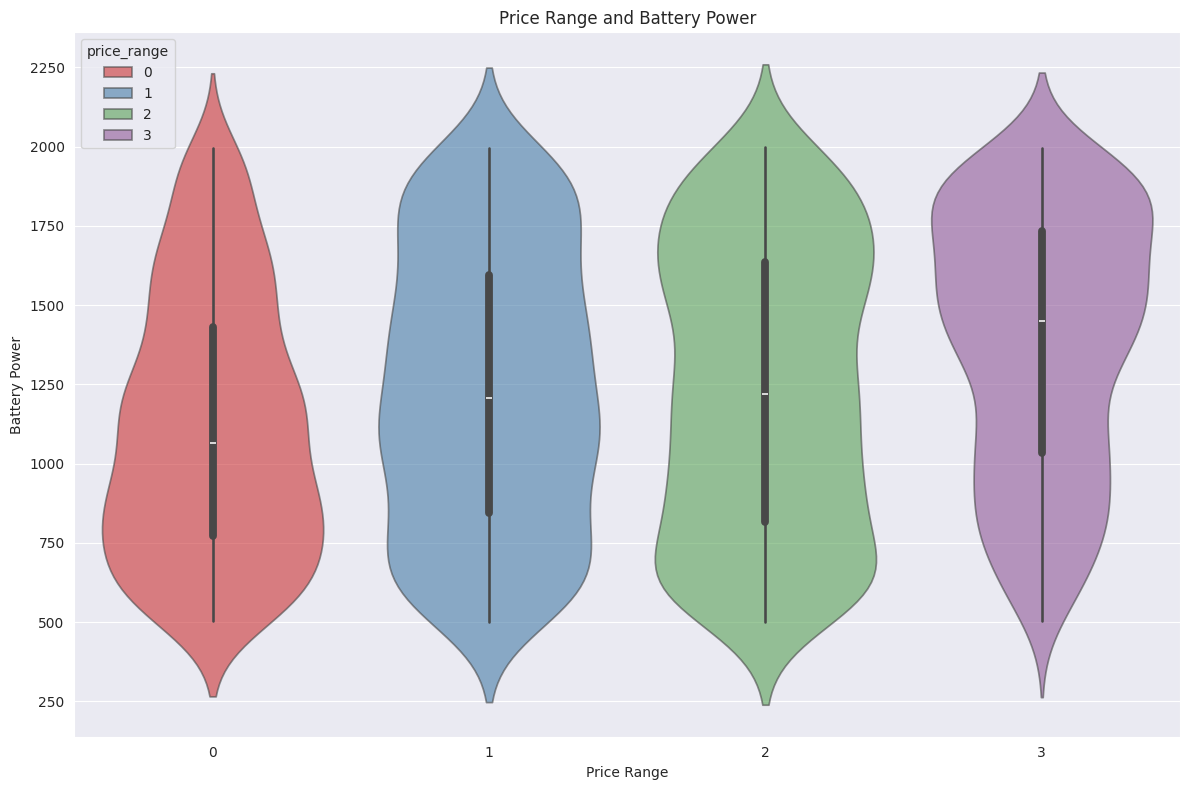

In [10]:
sns.violinplot(
    df,
    x='price_range',
    y='battery_power',
    hue='price_range',
    palette='Set1',
    alpha=0.6
)
plt.title('Price Range and Battery Power')
plt.xlabel('Price Range')
plt.ylabel('Battery Power')
plt.tight_layout()

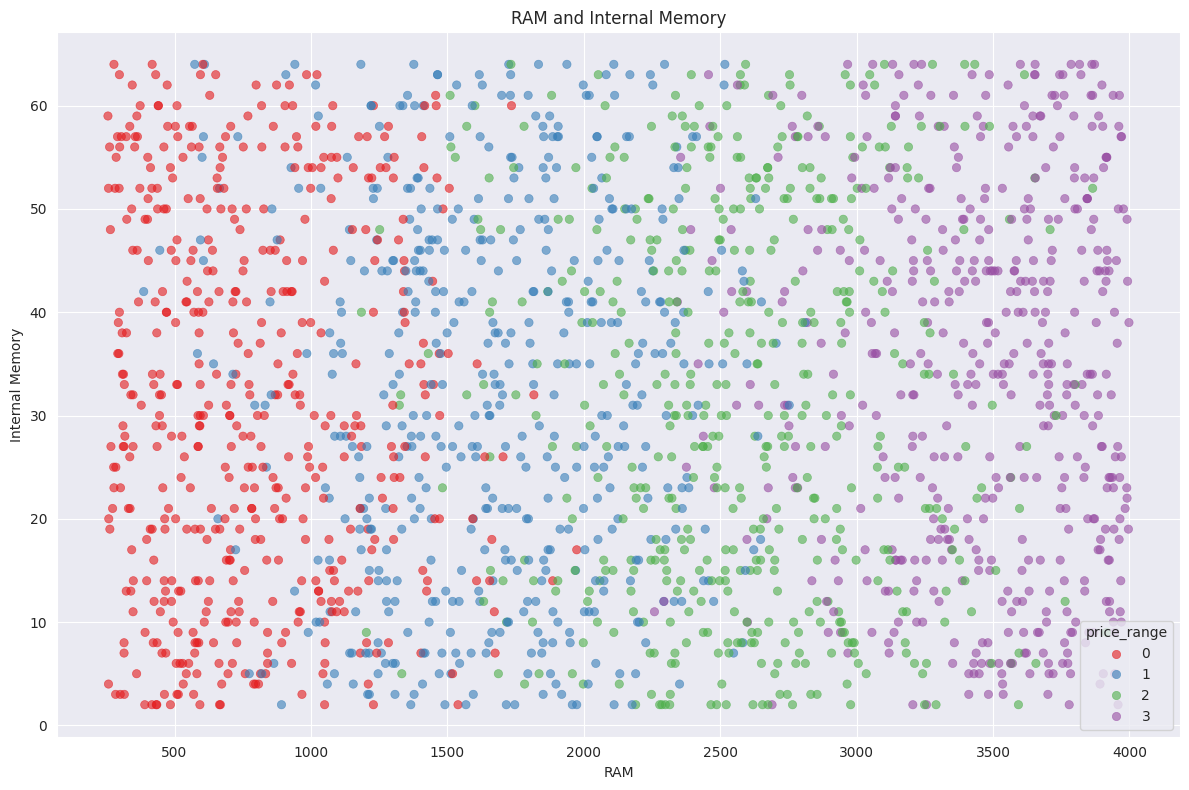

In [11]:
sns.scatterplot(
    df,
    x='ram',
    y='int_memory',
    hue='price_range',
    palette='Set1',
    edgecolor=None,
    alpha=0.6
)
plt.title('RAM and Internal Memory')
plt.xlabel('RAM')
plt.ylabel('Internal Memory')
plt.tight_layout()

Last but not least, let's visualize the relationship between the price range and the other variables.

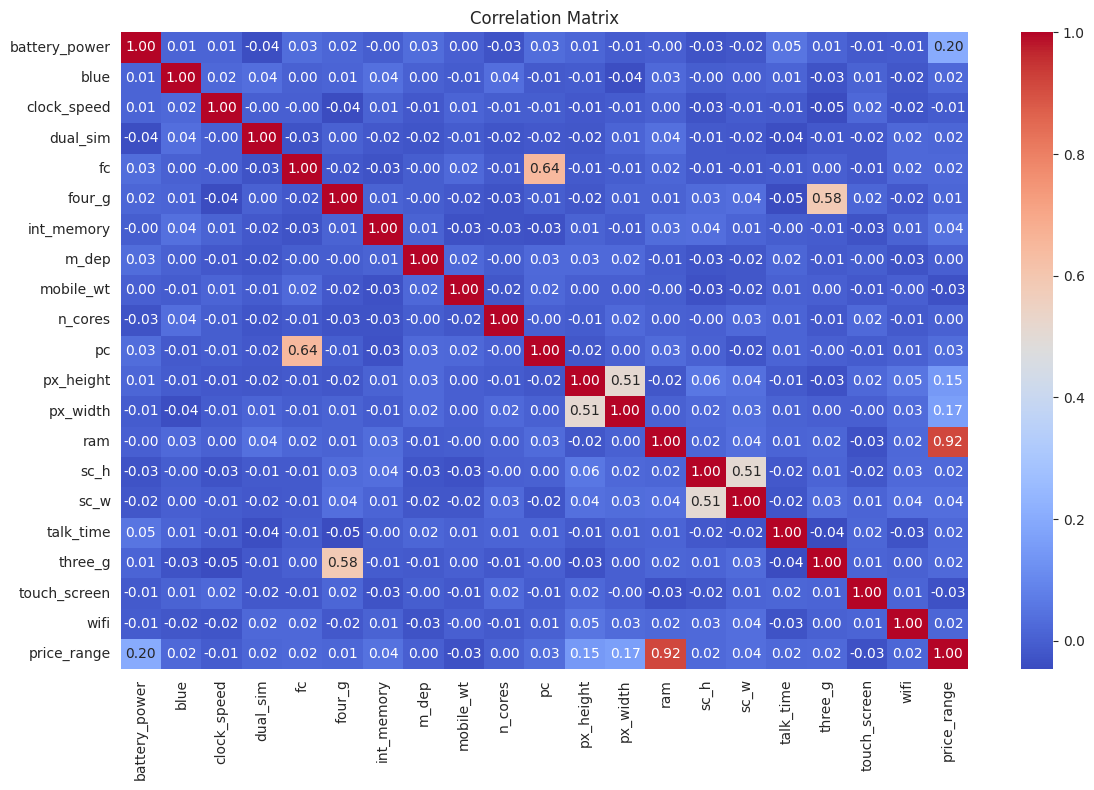

In [12]:
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()

## 4. Data Preprocessing
Let's make the data ready for the machine learning model.

In [14]:
df.corr()['price_range'].sort_values(ascending=False)

price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64

Drop the columns that are less correlated with `price_range`

In [107]:
x = df.drop(columns=['price_range', 'm_dep', 'n_cores', 'four_g', 'dual_sim', 'wifi', 'blue', 'clock_speed', 'fc', 'sc_h', 'three_g', 'pc', 'sc_w'])
y = df['price_range']

In [108]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [109]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

## 5. Model Building
Let's write a function to build and evaluate the machine learning models.

In [110]:
models = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'LogisticRegression': LogisticRegression(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
    'SVC': SVC()
}

def evaluate(x_train, y_train, x_test, y_test):
    results = []

    for i, (model_name, model) in enumerate(tqdm(models.items())):
        print(f'Training {model_name}...')
        y_pred = model.fit(x_train, y_train).predict(x_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        plt.subplot(2, 5, i+1)
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(model_name)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()

        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
        
    plt.suptitle('Confusion Matrices of All Models')
    plt.tight_layout()
    
    report = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
    report.reset_index(drop=True, inplace=True)
    return report

  0%|          | 0/10 [00:00<?, ?it/s]

Training GaussianNB...
Training MultinomialNB...
Training BernoulliNB...
Training LogisticRegression...
Training ExtraTreesClassifier...
Training DecisionTreeClassifier...
Training RandomForestClassifier...
Training GradientBoostingClassifier...
Training KNeighborsClassifier...
Training SVC...


,Model,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,0.9675,0.966679,0.967070,0.966807
1,RandomForestClassifier,0.9175,0.915070,0.916315,0.915526
2,SVC,0.9100,0.906732,0.907737,0.906985
3,ExtraTreesClassifier,0.9050,0.902592,0.903886,0.902757
4,GradientBoostingClassifier,0.9000,0.897991,0.899541,0.898199
5,DecisionTreeClassifier,0.8500,0.847482,0.846637,0.845846
6,GaussianNB,0.8025,0.803069,0.797104,0.798328
7,KNeighborsClassifier,0.7475,0.747677,0.742728,0.742815
8,MultinomialNB,0.5575,0.607433,0.561013,0.563920
9,BernoulliNB,0.2475,0.123598,0.270395,0.169605


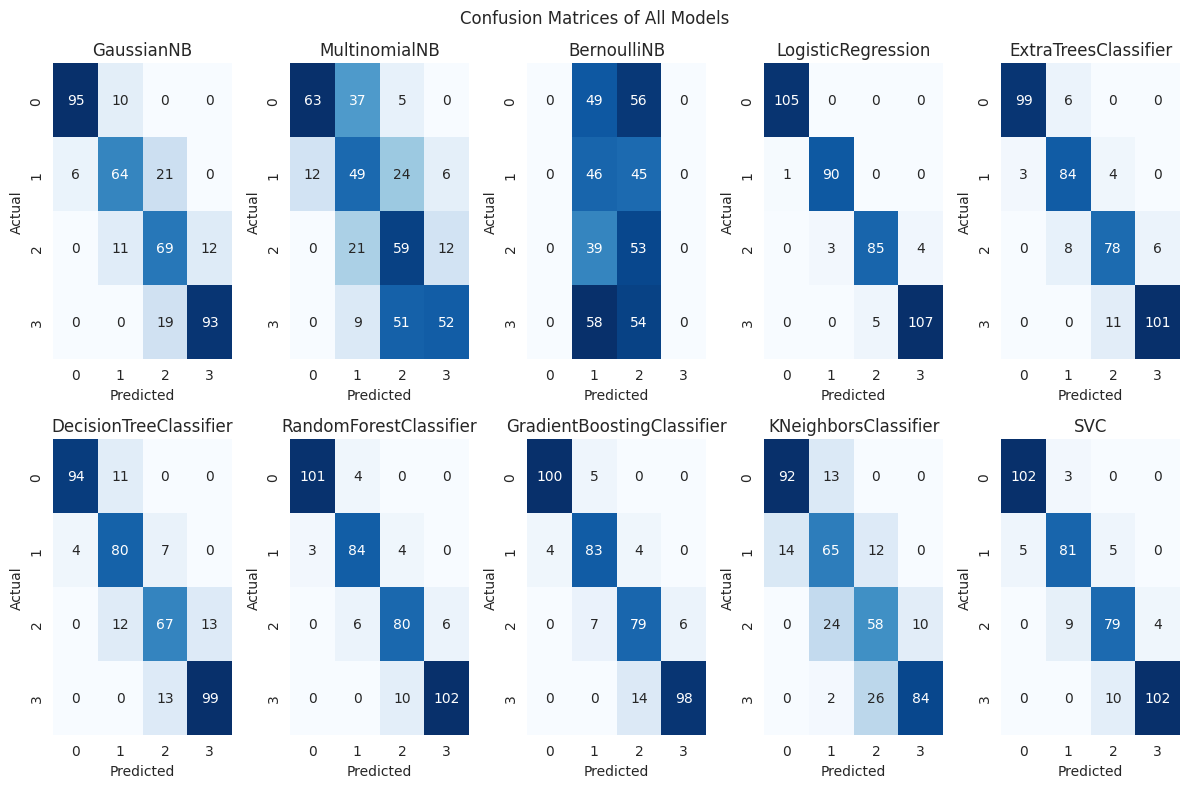

In [111]:
evaluate(x_train, y_train, x_test, y_test)

`LogisticRegression` is the best model for this dataset.

## 6. Model Saving
Let's create a pipeline and save it.

In [113]:
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), x.columns)
])

In [115]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])
pipeline.fit(x, y)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [118]:
y_pred = pipeline.predict(x)

print(f"Accuracy: {accuracy_score(y, y_pred)}")

Accuracy: 0.959


In [119]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       500
           1       0.94      0.94      0.94       500
           2       0.97      0.90      0.93       500
           3       0.96      0.99      0.98       500

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



Let's save the pipeline.

In [120]:
joblib.dump(pipeline, 'mobile_price_classification.pkl')

['mobile_price_classification.pkl']

## 7. Conclusion
In this project, we framed smartphone pricing as a multi-class classification task and used device specifications to predict the discrete `price_range` a phone belongs to.
Exploratory analysis showed that features like `ram`, `battery_power`, and some storage attributes have strong relationships with the target, while others contribute marginally.

We trained a suite of baseline and ensemble models. Among them, `LogisticRegression` achieved the strongest performance on the hold-out set in our experiments, offering a solid balance of accuracy, speed, and interpretability (via model coefficients).

To operationalize the solution, we built a preprocessing + model pipeline and saved it to disk as `mobile_price_classification.pkl`. This makes the workflow reproducible and easy to deploy.

### Next steps and improvements
- Perform systematic hyperparameter tuning (e.g., `LogisticRegression` C/penalty, solver).
- Use cross-validation and stratified splits for more reliable estimates.
- Engineer additional features (e.g., pixel density, aspect ratio) and remove redundant ones.
- Calibrate probabilities if downstream decisions rely on well-calibrated outputs.
- Track experiments and models (e.g., MLflow) and consider deployment (REST API or batch).

In [123]:
x.describe().T

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.5185,439.418206,501.0,851.75,1226.0,1615.25,1998.0
int_memory,2000.0,32.0465,18.145715,2.0,16.00,32.0,48.00,64.0
mobile_wt,2000.0,140.2490,35.399655,80.0,109.00,141.0,170.00,200.0
px_height,2000.0,645.1080,443.780811,0.0,282.75,564.0,947.25,1960.0
px_width,2000.0,1251.5155,432.199447,500.0,874.75,1247.0,1633.00,1998.0
ram,2000.0,2124.2130,1084.732044,256.0,1207.50,2146.5,3064.50,3998.0
talk_time,2000.0,11.0110,5.463955,2.0,6.00,11.0,16.00,20.0
touch_screen,2000.0,0.5030,0.500116,0.0,0.00,1.0,1.00,1.0
